In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from pymodulon.io import *
from os import path
import numpy as np
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
import mplcursors
import math
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

data_dir = path.join('..','data','processed_data')
interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(data_dir,'ZM4_ica.json.gz'))

/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' 

In [5]:
# look for iMs with largest changes
df = ica_data.sample_table
df = df[df['study'] == 'oxygen_shock']
df2 = pd.DataFrame(index = ica_data.A.index)#ica_data.A[df.index]
df2['var'] = ica_data.A[df.index].var(axis = 1)
df2['avg'] = ica_data.A[df.index].mean(axis = 1)
df2['range'] = ica_data.A[df.index].max(axis = 1) - ica_data.A[df.index].min(axis = 1)
df2.sort_values(by = ['var'], ascending = False).head()

,var,avg,range
DNA_repair_maybe,61.887048,10.334495,23.866188
translation_1,35.627136,-2.224235,22.268211
oxidation_response_2,23.501650,4.544372,12.902871
glycolysis_and_ATP_synthase,23.046449,-1.533603,19.439763
ethanol_fermentation,17.643744,4.910957,14.880296


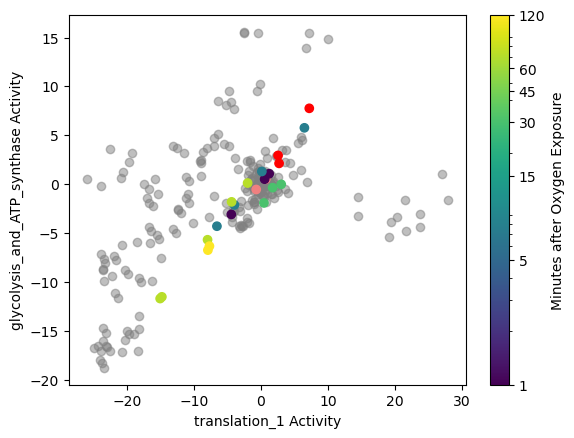

In [9]:
# settings
iM1 = 'translation_1'
iM2 = 'glycolysis_and_ATP_synthase'
use_log = True
base = 2

if True:
    def int_to_color(value, X, Y, base = 10, use_log = True, colormap='viridis'):
        # X is min, Y is max
        if type(value) == str:
            if 'anaerobic' in value:
                if '60' in value:
                    return 'red'
                else:
                    return 'lightcoral'
            else:
                value = int(value.split('_t')[1])
        if value == 0:
            value = 1

        if use_log:
            # Apply Log transformation to the value for coloring
            log_value = math.log(value, base)  # Use log base 10 for the scale
            # Normalize the log-transformed value to the range [0, 1]
            normalized_value = (log_value - math.log(X, base)) / (math.log(Y, base) - math.log(X, base))
        else:
            normalized_value = (value - X) / (Y - X)
        
        return normalized_value#color
    
    fig, ax = plt.subplots()
    
    # plotting scatter with colors
    highlight_samples = df.index
    other = list(set(ica_data.sample_table.index) - set(highlight_samples))
    controls = df[['anaerobic' in val for val in df.condition]]
    experiments = df[['anaerobic' not in val for val in df.condition]]

    # plot the rest
    scatter = ax.scatter(ica_data.A[other].loc[iM1], ica_data.A[other].loc[iM2], c='grey', alpha=0.5)

    # plot the controls
    colors = [int_to_color(value, 1, 120, base = base, use_log = use_log, colormap = 'viridis') for value in controls.condition]
    scatter2 = ax.scatter(ica_data.A[controls.index].loc[iM1], 
                           ica_data.A[controls.index].loc[iM2], 
                           c=colors)
    
    # plot the experiments
    colors = [int_to_color(value, 1, 120, base = base, use_log = use_log, colormap = 'viridis') for value in experiments.condition]
    scatter3 = ax.scatter(ica_data.A[experiments.index].loc[iM1], 
                           ica_data.A[experiments.index].loc[iM2], 
                           c=colors)
    
    # Create the colorbar with a logarithmic normalization
    if use_log:
        norm = LogNorm(vmin=1, vmax=120)  # LogNorm for the color scale
    else:
        norm = Normalize(vmin=0, vmax=120)
        
    cbar = plt.colorbar(cm.ScalarMappable(cmap='viridis', norm=norm), ax=ax, orientation='vertical')
    cbar.set_label('Minutes after Oxygen Exposure')
    
    # Set ticks for the colorbar (logarithmic scale)
    ticks = [1, 5, 15, 30, 45, 60, 120]  # Logarithmic ticks
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{int(t)}' for t in ticks])  # Integer tick labels
    
    # Label axes
    plt.xlabel(iM1 + ' Activity')
    plt.ylabel(iM2 + ' Activity')
    
    # Add interactive cursor for hovering
    cursor = mplcursors.cursor(scatter2, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(highlight_samples[sel.index])  # Show label for hovered point
    
    # Save and show
    plt.savefig('../figures/oxygen_response_iMs.pdf', transparent=True)
    plt.show()
